In [2]:
import pandas as pd 
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image

from torchvision.utils import make_grid
from torchvision.utils import save_image
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
#loading images into a pandas dataframe

dataframe = pd.DataFrame(columns=["img_name"])
dataframe["img_name"] = os.listdir("dataloader1/images1")
#for idx, i in enumerate(os.listdir("train/")):

dataframe.to_csv (r'dataset.csv', index = False, header=True)


In [4]:
#we create a dataloader class to modify our image spec and split our images in batches
class dataloader(Dataset):
    def __init__(self,root_dir,filename,transform=None):
        self.root_dir = root_dir
        self.filename = pd.read_csv(filename)
        self.transform = transform
        
    def __len__(self):
        return len(self.filename)
    
    #https://stackoverflow.com/questions/43627405/understanding-getitem-method
    def __getitem__(self,index):
        img_id = self.filename.iloc[index,0]
        img = Image.open(os.path.join(self.root_dir,img_id)).convert("L")
        
        if self.transform is not None:
            img=self.transform(img)
            
        return img

In [5]:
transform = transforms.Compose(
        [
            transforms.Resize((200, 200)),
            transforms.ToTensor(),  ## pixel range from 0-255 to 0-1 and datatype from numpy to tensor
            transforms.Normalize((0.5,), (0.5,)) ## range from 0-1 to -1 ,1 column rgb and rows mean and std
        ]
    )

In [6]:
a.info()

NameError: name 'a' is not defined

In [7]:
a = pd.read_csv("dataset.csv")

In [8]:
batch_size = 2
shuffle = True
rootdir = 'dataloader1/images1'
dataset = dataloader(rootdir,"dataset.csv",transform=transform)

train_set, validation_set = torch.utils.data.random_split(dataset,[430,108]) #,[431,108])

train_loader = DataLoader(dataset=train_set, shuffle=shuffle,batch_size=batch_size,drop_last=True)
validation_loader = DataLoader(dataset=validation_set, shuffle=shuffle,batch_size=batch_size,drop_last=True)

In [9]:
# Checking the dataset
print('Training Set:\n')
for images in train_loader:  
    print('Image batch dimensions:', images.size())
    break
    
# Checking the dataset
print('\nValidation Set:')
for images in validation_loader:  
    print('Image batch dimensions:', images.size())
    break


Training Set:

Image batch dimensions: torch.Size([2, 1, 200, 200])

Validation Set:
Image batch dimensions: torch.Size([2, 1, 200, 200])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


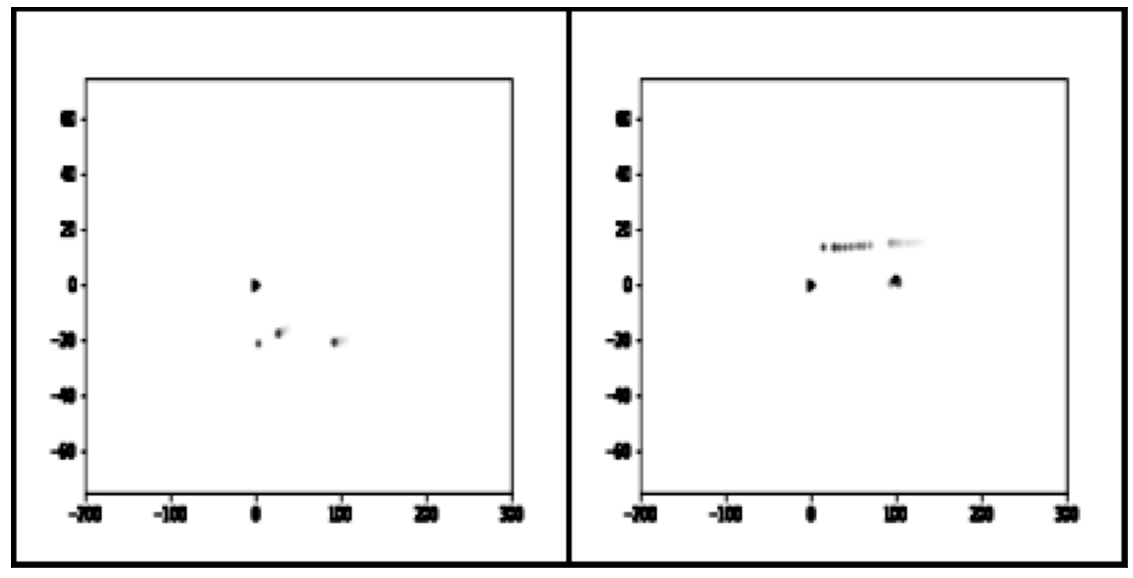

In [10]:
from torchvision.utils import make_grid
def show_images(images, nmax=250):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def show_batch(dl, nmax=250):
    for images in dl:
        show_images(images, nmax)
        break
        
show_batch(train_loader)

In [15]:
def calculateconv(pixel,filters,padding,stride):
    output = (pixel - filters +(2*padding))/stride
    return output + 1

def calculatedecon(pixel,filters,padding,stride):
    output = stride*(pixel - 1)+filters -(2*padding)
    return output


In [16]:
print(calculateconv(200,3,1,2))
print(calculateconv(100,3,1,2))
print(calculateconv(50,3,1,2))
print(calculateconv(25,3,1,2))
print(calculateconv(13,3,0,2))
print("\n")
print(calculatedecon(6,3,0,2))
print(calculatedecon(13,3,1,2))
print(calculatedecon(25,3,1,2))
print(calculatedecon(49,3,0,2))
print(calculatedecon(99,4,0,2))

100.5
50.5
25.5
13.0
6.0


13
25
49
99
200


In [17]:
### Batch normalization test
torch.manual_seed(10)
class ConvolutionAE(nn.Module):    
    def __init__(self):
        super().__init__()
        
        ## Encoder 
        self.layer1 = nn.Conv2d(1,10,kernel_size=(3, 3), padding=1,stride=(2, 2)) # 100.5
        self.encoder_bn1 = nn.BatchNorm2d(10)
        self.layer2 = nn.Conv2d(10,20,kernel_size=(3, 3), padding=1,stride=(2, 2)) #26
        self.encoder_bn2 = nn.BatchNorm2d(20)
        self.layer3 = nn.Conv2d(20,30,kernel_size=(3, 3), padding=1,stride=(2, 2)) #7
        self.encoder_bn3 = nn.BatchNorm2d(30)
        self.layer4 = nn.Conv2d(30,40,kernel_size=(3, 3), padding=1,stride=(2, 2))
        self.encoder_bn4 = nn.BatchNorm2d(40)
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3),stride=(2, 2),return_indices=True) #50
        self.Flatten = nn.Flatten()
        
        ## Latent Dim 
        self.latent1 = nn.Linear(1440,500)
        self.latent_bn1 = nn.BatchNorm1d(500)
        self.LinearD = nn.Linear(500,1440)
        self.latent_bn2 = nn.BatchNorm1d(1440)
        
        ## DECODER --->s(n-1)+f-2p
        self.poolt1 = nn.MaxUnpool2d(kernel_size=(3, 3),stride=(2, 2)) #27       
        self.convt1 = nn.ConvTranspose2d(40, 30 ,kernel_size=(3, 3), padding=1,stride=(2, 2)) #13
        self.decoder_bn2 = nn.BatchNorm2d(30)
        self.convt2 = nn.ConvTranspose2d(30, 20 ,kernel_size=(3, 3), padding=1,stride=(2, 2)) #52
        self.decoder_bn3 = nn.BatchNorm2d(20)
        self.convt3 = nn.ConvTranspose2d(20, 10 ,kernel_size=(3, 3), padding=0,stride=(2, 2))
        self.decoder_bn4 = nn.BatchNorm2d(10)
        self.convt4 = nn.ConvTranspose2d(10, 1 ,kernel_size=(4, 4), padding=0,stride=(2, 2))
        
        
    def forward(self,x):
        ## Encoder 
        x = F.leaky_relu(self.encoder_bn1(self.layer1(x)))
        x = F.leaky_relu(self.encoder_bn2(self.layer2(x)))
        x = F.leaky_relu(self.encoder_bn3(self.layer3(x)))
        x = F.leaky_relu(self.encoder_bn4(self.layer4(x)))
        x,ind1 = self.pool1(x)
        ## LATENT
        x = self.Flatten(x)
        x = self.latent_bn1(self.latent1(x))
        x = self.latent_bn2(self.LinearD(x))
        x = x.reshape(-1,40,6,6)
        ## Decoder
        x = self.poolt1(x,ind1)
        x = F.leaky_relu(self.decoder_bn2(self.convt1(x)))
        x = F.leaky_relu(self.decoder_bn3(self.convt2(x)))
        x = F.leaky_relu(self.decoder_bn4(self.convt3(x)))
        x = F.sigmoid(self.convt4(x))

        
        return x

    def embedded_space(self,x):
        ## Encoder 
        x = F.leaky_relu(self.encoder_bn1(self.layer1(x)))
        x = F.leaky_relu(self.encoder_bn2(self.layer2(x)))
        x = F.leaky_relu(self.encoder_bn3(self.layer3(x)))
        x = F.leaky_relu(self.encoder_bn4(self.layer4(x)))
        x,ind1 = self.pool1(x)
        ## LATENT
        x = self.Flatten(x)
        x = self.latent_bn1(self.latent1(x))
        return x
        

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvolutionAE()
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4,weight_decay=1e-5)

In [19]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [20]:
from torchinfo import summary

In [21]:
model = ConvolutionAE()
batch_size = 6
summary(model, input_size=(batch_size, 1, 200, 200))

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Layer (type:depth-idx)                   Output Shape              Param #
ConvolutionAE                            --                        --
├─Conv2d: 1-1                            [6, 10, 100, 100]         100
├─BatchNorm2d: 1-2                       [6, 10, 100, 100]         20
├─Conv2d: 1-3                            [6, 20, 50, 50]           1,820
├─BatchNorm2d: 1-4                       [6, 20, 50, 50]           40
├─Conv2d: 1-5                            [6, 30, 25, 25]           5,430
├─BatchNorm2d: 1-6                       [6, 30, 25, 25]           60
├─Conv2d: 1-7                            [6, 40, 13, 13]           10,840
├─BatchNorm2d: 1-8                       [6, 40, 13, 13]           80
├─MaxPool2d: 1-9                         [6, 40, 6, 6]             --
├─Flatten: 1-10                          [6, 1440]                 --
├─Linear: 1-11                           [6, 500]                  720,500
├─BatchNorm1d: 1-12                      [6, 500]                  1,

In [22]:
model.eval()

ConvolutionAE(
  (layer1): Conv2d(1, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Conv2d(20, 30, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer4): Conv2d(30, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_bn4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (Flatten): Flatten()
  (latent1): Linear(in_features=1440, out_features=500, bias=True)
  (latent_bn1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (

In [23]:
def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"recon/output{epoch}.jpg")
def save_loss_plot(train_loss, valid_loss):
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/loss.jpg')
    plt.show()

In [24]:
def train(model, dataloader,device, optimizer, criterion):
    model.train()
    running_loss = 0.0  ### Batch wise loss value
    counter = 0 ## track of total number of training step
    for i, data in enumerate(dataloader):
        counter += 1
        images = data
        
        ### Clear Gradients
        optimizer.zero_grad()
        #initalize model
        reconstruction = model(images)
        #calculate Losses
        loss = criterion(reconstruction, images)
        #calculate gradient
        loss.backward()
        # Update weights
        optimizer.step()
        # total loss
        running_loss += loss.item()
    ## Avg of loss
    train_loss = running_loss /counter
    return train_loss

def validate(model, dataloader,dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            counter += 1
            images = data
            reconstruction = model(images)
            loss = criterion(reconstruction, images)
            # Update weights
            running_loss += loss.item()

            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction
    val_loss = running_loss/counter
    return val_loss, recon_images

In [25]:
print(len(train_set))
print(train_loader.batch_size)
## iteration needed to get all data from train_set
int(len(train_set)/train_loader.batch_size)

430
6


71

In [26]:
train_loss = []
valid_loss = []
grid_images = []
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model, train_loader, device, optimizer, criterion)
    valid_epoch_loss, recon_images = validate(model, validation_loader, validation_set, device, criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

Epoch 1 of 5
Train Loss: 0.2850
Val Loss: 0.2770
Epoch 2 of 5
Train Loss: 0.2849
Val Loss: 0.2778
Epoch 3 of 5
Train Loss: 0.2849
Val Loss: 0.2796
Epoch 4 of 5
Train Loss: 0.2850
Val Loss: 0.2791
Epoch 5 of 5
Train Loss: 0.2850
Val Loss: 0.2782


In [27]:
!tensorboard --logdir runs

/bin/sh: tensorboard: command not found


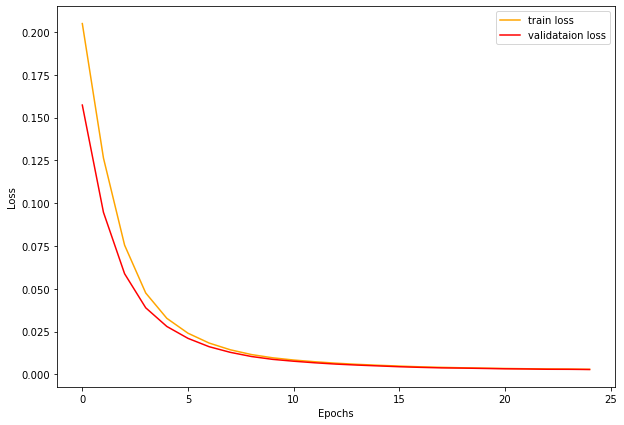

In [48]:
save_loss_plot(train_loss, valid_loss)


In [49]:
torch.save(model.state_dict(), "output")

In [69]:
model.load_state_dict(torch.load("output"))
model.eval()

RuntimeError: Error(s) in loading state_dict for DataParallel:
	Missing key(s) in state_dict: "module.layer1.weight", "module.layer1.bias", "module.encoder_bn1.weight", "module.encoder_bn1.bias", "module.encoder_bn1.running_mean", "module.encoder_bn1.running_var", "module.layer2.weight", "module.layer2.bias", "module.encoder_bn2.weight", "module.encoder_bn2.bias", "module.encoder_bn2.running_mean", "module.encoder_bn2.running_var", "module.layer3.weight", "module.layer3.bias", "module.encoder_bn3.weight", "module.encoder_bn3.bias", "module.encoder_bn3.running_mean", "module.encoder_bn3.running_var", "module.layer4.weight", "module.layer4.bias", "module.encoder_bn4.weight", "module.encoder_bn4.bias", "module.encoder_bn4.running_mean", "module.encoder_bn4.running_var", "module.latent1.weight", "module.latent1.bias", "module.latent_bn1.weight", "module.latent_bn1.bias", "module.latent_bn1.running_mean", "module.latent_bn1.running_var", "module.LinearD.weight", "module.LinearD.bias", "module.latent_bn2.weight", "module.latent_bn2.bias", "module.latent_bn2.running_mean", "module.latent_bn2.running_var", "module.convt1.weight", "module.convt1.bias", "module.decoder_bn2.weight", "module.decoder_bn2.bias", "module.decoder_bn2.running_mean", "module.decoder_bn2.running_var", "module.convt2.weight", "module.convt2.bias", "module.decoder_bn3.weight", "module.decoder_bn3.bias", "module.decoder_bn3.running_mean", "module.decoder_bn3.running_var", "module.convt3.weight", "module.convt3.bias", "module.decoder_bn4.weight", "module.decoder_bn4.bias", "module.decoder_bn4.running_mean", "module.decoder_bn4.running_var", "module.convt4.weight", "module.convt4.bias". 
	Unexpected key(s) in state_dict: "layer1.weight", "layer1.bias", "layer2.weight", "layer2.bias", "layer3.weight", "layer3.bias", "layer4.weight", "layer4.bias", "latent1.weight", "latent1.bias", "LinearD.weight", "LinearD.bias", "convt1.weight", "convt1.bias", "convt2.weight", "convt2.bias", "convt3.weight", "convt3.bias", "convt4.weight", "convt4.bias". 

In [51]:
import numpy as np
trail = dataloader(rootdir,"dataset.csv",transform=transform)
tril_loader = DataLoader(dataset=trail, batch_size=6)


In [117]:
#TSV File for embeddings
k= open("cnn_tsv.tsv","w+")
for i in range(0,5390):
    k.write(str(all_embed[i][0].item())) #first embedding dimension is here to avoid tab at the end
    for j in range(1,500):
        k.write("\t")
        k.write(str(all_embed[i][j].item()))  
    k.write("\n")

In [118]:
#Removing the empty line at the end
with open("cnn_tsv.tsv", 'r') as f:
    data = f.read()
    with open("embedding_CNN_final.tsv", 'w') as w:
        w.write(data)

In [13]:
!pip install torchsummary

In [14]:
from torchsummary import summary
summary(model,input_size=(1,200,200))

NameError: name 'model' is not defined

In [ ]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    for imgs in tqdm(data_loader, desc="Encoding images", leave=False):
        with torch.no_grad():
            z = model.encoder(imgs)
        img_list.append(imgs)
        embed_list.append(z)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0))

train_img_embeds = embed_imgs(model, train_loader)
test_img_embeds = embed_imgs(model, validation_loader)


In [ ]:
epochs = 20
for e in range(1, epochs+1):
    train_loss = 0.0  # monitor training loss
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        images = data                        # we are just intrested in images
        # no need to flatten images
        optimizer.zero_grad()                   # clear the gradients
        outputs = model(images)                 # forward pass: compute predicted outputs 
        loss = criterian(outputs, images)       # calculate the loss
        loss.backward()                         # backward pass
        optimizer.step()                        # perform optimization step
        train_loss += loss.item()*images.size(0)# update running training loss
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {}'.format(e),
          '\tTraining Loss: {:.4f}'.format(train_loss))

# Test run 2

In [20]:
### Batch normalization test
torch.manual_seed(10)
class ConvolutionAE(nn.Module):    
    def __init__(self):
        super().__init__()
        
        ## Encoder 
        self.layer1 = nn.Conv2d(1,10,kernel_size=(3, 3), padding=1,stride=(2, 2)) # 100.5
        self.encoder_bn1 = nn.BatchNorm2d(10)
        self.layer2 = nn.Conv2d(10,20,kernel_size=(3, 3), padding=1,stride=(2, 2)) #26
        self.encoder_bn2 = nn.BatchNorm2d(20)
        self.layer3 = nn.Conv2d(20,30,kernel_size=(3, 3), padding=1,stride=(2, 2)) #7
        self.encoder_bn3 = nn.BatchNorm2d(30)
        self.layer4 = nn.Conv2d(30,40,kernel_size=(3, 3), padding=1,stride=(2, 2))
        self.encoder_bn4 = nn.BatchNorm2d(40)
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3),stride=(2, 2),return_indices=True) #50
        self.Flatten = nn.Flatten()
        
        ## Latent Dim 
        self.latent1 = nn.Linear(1440,500)
        self.latent_bn1 = nn.BatchNorm1d(500)
        self.LinearD = nn.Linear(500,1440)
        self.latent_bn2 = nn.BatchNorm1d(1440)
        
        ## DECODER --->s(n-1)+f-2p
        self.poolt1 = nn.MaxUnpool2d(kernel_size=(3, 3),stride=(2, 2)) #27       
        self.convt1 = nn.ConvTranspose2d(40, 30 ,kernel_size=(3, 3), padding=1,stride=(2, 2)) #13
        self.decoder_bn2 = nn.BatchNorm2d(30)
        self.convt2 = nn.ConvTranspose2d(30, 20 ,kernel_size=(3, 3), padding=1,stride=(2, 2)) #52
        self.decoder_bn3 = nn.BatchNorm2d(20)
        self.convt3 = nn.ConvTranspose2d(20, 10 ,kernel_size=(3, 3), padding=0,stride=(2, 2))
        self.decoder_bn4 = nn.BatchNorm2d(10)
        self.convt4 = nn.ConvTranspose2d(10, 1 ,kernel_size=(4, 4), padding=0,stride=(2, 2))
        
        
    def forward(self,x):
        ## Encoder 
        x = F.leaky_relu(self.encoder_bn1(self.layer1(x)))
        x = F.leaky_relu(self.encoder_bn2(self.layer2(x)))
        x = F.leaky_relu(self.encoder_bn3(self.layer3(x)))
        x = F.leaky_relu(self.encoder_bn4(self.layer4(x)))
        x,ind1 = self.pool1(x)
        ## LATENT
        x = self.Flatten(x)
        x = self.latent_bn1(self.latent1(x))
        x = self.latent_bn2(self.LinearD(x))
        x = x.reshape(-1,40,6,6)
        ## Decoder
        x = self.poolt1(x,ind1)
        x = F.leaky_relu(self.decoder_bn2(self.convt1(x)))
        x = F.leaky_relu(self.decoder_bn3(self.convt2(x)))
        x = F.leaky_relu(self.decoder_bn4(self.convt3(x)))
        x = self.convt4(x)

        return x

    def embedded_space(self,x):
        ## Encoder 
        x = F.leaky_relu(self.encoder_bn1(self.layer1(x)))
        x = F.leaky_relu(self.encoder_bn2(self.layer2(x)))
        x = F.leaky_relu(self.encoder_bn3(self.layer3(x)))
        x = F.leaky_relu(self.encoder_bn4(self.layer4(x)))
        x,ind1 = self.pool1(x)
        ## LATENT
        x = self.Flatten(x)
        x = self.latent_bn1(self.latent1(x))
        return x
        

In [25]:
def save_decoded_image(img, name):
    img = img.reshape(img.size(0), 1, 200, 200)
    save_image(img, name)

In [23]:
def train(model, dataloader,device, optimizer, criterion):
    model.train()
    running_loss = 0.0  ### Batch wise loss value
    counter = 0 ## track of total number of training step
    for i, data in enumerate(dataloader):
        counter += 1
        images = data
        
        ### Clear Gradients
        optimizer.zero_grad()
        #initalize model
        reconstruction = model(images)
        #calculate Losses
        loss = criterion(reconstruction, images)
        #calculate gradient
        loss.backward()
        # Update weights
        optimizer.step()
        # total loss
        running_loss += loss.item()
        
        if epoch % 5 == 0:
            save_decoded_image(images.cpu().data, name='./outputs/test2/original{}.png'.format(epoch))
            save_decoded_image(reconstruction.cpu().data, name='./outputs/test2/decoded{}.png'.format(epoch))
    ## Avg of loss
    train_loss = running_loss /counter
    return train_loss

def validate(model, dataloader,dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            counter += 1
            images = data
            reconstruction = model(images)
            loss = criterion(reconstruction, images)
            # Update weights
            running_loss += loss.item()
            reconstruction = reconstruction.reshape(reconstruction.size(0),1,200,200)
            save_image(reconstruction, 'outputs/test2/testrun.png')
            # save the last batch input and output of every epoch
            
    val_loss = running_loss/counter
    return val_loss

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvolutionAE()
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4,weight_decay=1e-5)

In [24]:
train_loss = []
valid_loss = []
grid_images = []
epochs = 30
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model, train_loader, device, optimizer, criterion)
    valid_epoch_loss = validate(model, validation_loader, validation_set, device, criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

Epoch 1 of 30
Train Loss: 0.7377
Val Loss: 0.4110
Epoch 2 of 30
Train Loss: 0.2450
Val Loss: 0.1317
Epoch 3 of 30
Train Loss: 0.0798
Val Loss: 0.0468
Epoch 4 of 30
Train Loss: 0.0347
Val Loss: 0.0271
Epoch 5 of 30
Train Loss: 0.0243
Val Loss: 0.0227
Epoch 6 of 30
Train Loss: 0.0211
Val Loss: 0.0200
Epoch 7 of 30
Train Loss: 0.0192
Val Loss: 0.0182
Epoch 8 of 30
Train Loss: 0.0177
Val Loss: 0.0168
Epoch 9 of 30
Train Loss: 0.0164
Val Loss: 0.0156
Epoch 10 of 30
Train Loss: 0.0151
Val Loss: 0.0143
Epoch 11 of 30
Train Loss: 0.0137
Val Loss: 0.0127
Epoch 12 of 30
Train Loss: 0.0120
Val Loss: 0.0112
Epoch 13 of 30
Train Loss: 0.0106
Val Loss: 0.0098
Epoch 14 of 30
Train Loss: 0.0095
Val Loss: 0.0087
Epoch 15 of 30
Train Loss: 0.0087
Val Loss: 0.0081
Epoch 16 of 30
Train Loss: 0.0079
Val Loss: 0.0075
Epoch 17 of 30
Train Loss: 0.0074
Val Loss: 0.0068
Epoch 18 of 30
Train Loss: 0.0068
Val Loss: 0.0064
Epoch 19 of 30
Train Loss: 0.0064
Val Loss: 0.0059
Epoch 20 of 30
Train Loss: 0.0059
Val Lo

In [ ]:
train_loss = []
valid_loss = []
epochs = 25
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model, train_loader, device, optimizer, criterion)
    valid_epoch_loss = validate(model, validation_loader, validation_set, device, criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

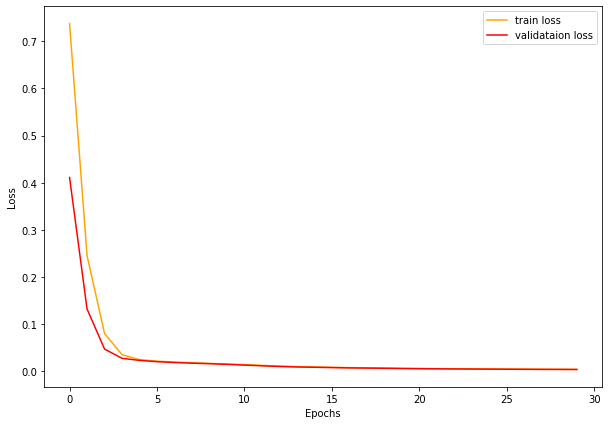

In [25]:
save_loss_plot(train_loss, valid_loss)

In [15]:
torch.save(model.state_dict(), "output1")

NameError: name 'model' is not defined

In [16]:
modelload = ConvolutionAE()
modelload.load_state_dict(torch.load("output1"))
modelload.eval()

ConvolutionAE(
  (layer1): Conv2d(1, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Conv2d(20, 30, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer4): Conv2d(30, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_bn4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (Flatten): Flatten()
  (latent1): Linear(in_features=1440, out_features=500, bias=True)
  (latent_bn1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (

In [18]:
from torchsummary import summary
summary(modelload,input_size=(1,200,200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 100, 100]             100
       BatchNorm2d-2         [-1, 10, 100, 100]              20
            Conv2d-3           [-1, 20, 50, 50]           1,820
       BatchNorm2d-4           [-1, 20, 50, 50]              40
            Conv2d-5           [-1, 30, 25, 25]           5,430
       BatchNorm2d-6           [-1, 30, 25, 25]              60
            Conv2d-7           [-1, 40, 13, 13]          10,840
       BatchNorm2d-8           [-1, 40, 13, 13]              80
         MaxPool2d-9  [[-1, 40, 6, 6], [-1, 40, 6, 6]]               0
          Flatten-10                 [-1, 1440]               0
           Linear-11                  [-1, 500]         720,500
      BatchNorm1d-12                  [-1, 500]           1,000
           Linear-13                 [-1, 1440]         721,440
      BatchNorm1d-14            

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [44]:
torch.manual_seed(10)
code5 = pd.DataFrame()
for img in train_loader:
    image = img
    embeddedspace = modelload.embedded_space(image)       
    DF =pd.DataFrame(embeddedspace.detach().numpy())
    code5= code5.append(DF)

In [45]:
code5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1392 entries, 0 to 5
Columns: 500 entries, 0 to 499
dtypes: float32(500)
memory usage: 2.7 MB


In [46]:
code5.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.043785,0.529435,0.061397,-0.543105,0.579578,-0.782372,2.381325,1.670548,-0.880170,0.292367,...,0.868448,0.578503,0.385241,-0.902872,-1.127024,-0.116779,-0.892887,-0.700994,-0.162459,-0.134418
1,-0.174736,-0.018390,-0.812510,0.180142,0.282951,0.031070,0.162825,-1.053603,1.011696,-0.386526,...,0.390868,-0.134034,-0.282229,-0.096693,0.571054,0.244309,0.869729,0.655014,-0.079085,-0.352734
2,-0.200030,-0.227382,-0.919416,-0.372155,-0.337635,0.517235,0.834290,-0.121502,0.155059,-0.581583,...,0.874789,0.726861,-0.764218,0.511044,0.107359,0.660393,0.705435,0.439761,-0.165348,0.619356
3,0.341937,-0.771196,-0.146698,-0.905717,-0.469351,-1.563748,1.278605,0.032982,-0.373717,0.287810,...,0.220122,0.347598,0.271744,-1.102592,0.856475,-0.331914,0.117631,-0.070143,0.288659,-0.178347
4,-0.534345,-0.245603,-0.339538,-0.057639,-0.440808,-0.632861,-0.212702,-0.877314,0.238795,0.169737,...,1.122443,0.107826,-0.306514,0.610748,-0.169148,-0.245378,-0.108793,0.530392,0.123131,-1.182010


In [48]:
code5.to_csv("testrun.tsv", sep="\t", index=True)

# Test run 3

In [19]:
### Batch normalization test
torch.manual_seed(10)
class ConvolutionAE(nn.Module):    
    def __init__(self):
        super().__init__()
        
        ## Encoder 
        self.layer1 = nn.Conv2d(1,10,kernel_size=(3, 3), padding=1,stride=(2, 2)) # 100.5
        self.encoder_bn1 = nn.BatchNorm2d(10)
        self.layer2 = nn.Conv2d(10,20,kernel_size=(3, 3), padding=1,stride=(2, 2)) #26
        self.encoder_bn2 = nn.BatchNorm2d(20)
        self.layer3 = nn.Conv2d(20,30,kernel_size=(3, 3), padding=1,stride=(2, 2)) #7
        self.encoder_bn3 = nn.BatchNorm2d(30)
        self.layer4 = nn.Conv2d(30,40,kernel_size=(3, 3), padding=1,stride=(2, 2))
        self.encoder_bn4 = nn.BatchNorm2d(40)
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3),stride=(2, 2),return_indices=True) #50
        self.Flatten = nn.Flatten()
        
        ## Latent Dim 
        self.latent1 = nn.Linear(1440,500)
        self.latent_bn1 = nn.BatchNorm1d(500)
        self.LinearD = nn.Linear(500,1440)
        self.latent_bn2 = nn.BatchNorm1d(1440)
        
        ## DECODER --->s(n-1)+f-2p
        self.poolt1 = nn.MaxUnpool2d(kernel_size=(3, 3),stride=(2, 2)) #27       
        self.convt1 = nn.ConvTranspose2d(40, 30 ,kernel_size=(3, 3), padding=1,stride=(2, 2)) #13
        self.decoder_bn2 = nn.BatchNorm2d(30)
        self.convt2 = nn.ConvTranspose2d(30, 20 ,kernel_size=(3, 3), padding=1,stride=(2, 2)) #52
        self.decoder_bn3 = nn.BatchNorm2d(20)
        self.convt3 = nn.ConvTranspose2d(20, 10 ,kernel_size=(3, 3), padding=0,stride=(2, 2))
        self.decoder_bn4 = nn.BatchNorm2d(10)
        self.convt4 = nn.ConvTranspose2d(10, 1 ,kernel_size=(4, 4), padding=0,stride=(2, 2))
        
        
    def forward(self,x):
        ## Encoder 
        x = F.leaky_relu(self.encoder_bn1(self.layer1(x)))
        x = F.leaky_relu(self.encoder_bn2(self.layer2(x)))
        x = F.leaky_relu(self.encoder_bn3(self.layer3(x)))
        x = F.leaky_relu(self.encoder_bn4(self.layer4(x)))
        x,ind1 = self.pool1(x)
        ## LATENT
        x = self.Flatten(x)
        x = self.latent_bn1(self.latent1(x))
        x = self.latent_bn2(self.LinearD(x))
        x = x.reshape(-1,40,6,6)
        ## Decoder
        x = self.poolt1(x,ind1)
        x = F.leaky_relu(self.decoder_bn2(self.convt1(x)))
        x = F.leaky_relu(self.decoder_bn3(self.convt2(x)))
        x = F.leaky_relu(self.decoder_bn4(self.convt3(x)))
        x = F.sigmoid(self.convt4(x))

        return x

    def embedded_space(self,x):
        ## Encoder 
        x = F.leaky_relu(self.encoder_bn1(self.layer1(x)))
        x = F.leaky_relu(self.encoder_bn2(self.layer2(x)))
        x = F.leaky_relu(self.encoder_bn3(self.layer3(x)))
        x = F.leaky_relu(self.encoder_bn4(self.layer4(x)))
        x,ind1 = self.pool1(x)
        ## LATENT
        x = self.Flatten(x)
        x = self.latent_bn1(self.latent1(x))
        return x
        

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvolutionAE()
criterion = nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4,weight_decay=1e-5)

In [ ]:
train_loss = []
valid_loss = []
grid_images = []
epochs = 30
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model, train_loader, device, optimizer, criterion)
    valid_epoch_loss = validate(model, validation_loader, validation_set, device, criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

Epoch 1 of 30
Train Loss: 0.5976
Val Loss: 0.5002
Epoch 2 of 30
Train Loss: 0.4230
Val Loss: 0.3556
Epoch 3 of 30
Train Loss: 0.3007
Val Loss: 0.2510
Epoch 4 of 30
Train Loss: 0.2148
Val Loss: 0.1822
Epoch 5 of 30
Train Loss: 0.1578
Val Loss: 0.1364
Epoch 6 of 30
Train Loss: 0.1180
Val Loss: 0.1031
Epoch 7 of 30
Train Loss: 0.0896
Val Loss: 0.0788
Epoch 8 of 30
Train Loss: 0.0694
Val Loss: 0.0621
Epoch 9 of 30
Train Loss: 0.0548
Val Loss: 0.0490
Epoch 10 of 30
Train Loss: 0.0440
Val Loss: 0.0396
Epoch 11 of 30
Train Loss: 0.0361
Val Loss: 0.0327
Epoch 12 of 30
Train Loss: 0.0301
Val Loss: 0.0274
Epoch 13 of 30
Train Loss: 0.0253
Val Loss: 0.0229
Epoch 14 of 30
Train Loss: 0.0214
Val Loss: 0.0192
Epoch 15 of 30
Train Loss: 0.0180
Val Loss: 0.0153
Epoch 16 of 30
Train Loss: 0.0149
Val Loss: 0.0123
Epoch 17 of 30
Train Loss: 0.0120
Val Loss: 0.0093
Epoch 18 of 30
Train Loss: 0.0097
Val Loss: 0.0070
Epoch 19 of 30


In [ ]:
def train(model, dataloader,device, optimizer, criterion):
    model.train()
    running_loss = 0.0  ### Batch wise loss value
    counter = 0 ## track of total number of training step
    for i, data in enumerate(dataloader):
        counter += 1
        images = data
        
        ### Clear Gradients
        optimizer.zero_grad()
        #initalize model
        reconstruction = model(images)
        #calculate Losses
        loss = criterion(reconstruction, images)
        #calculate gradient
        loss.backward()
        # Update weights
        optimizer.step()
        
        # total loss
        running_loss += loss.item()

        #writer.add_scalar("train loss",loss,global_step=counter)
    train_loss = running_loss /len(dataloader)
    return train_loss

def validate(model, dataloader,dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            counter += 1
            images = data
            reconstruction = model(images)
            loss = criterion(reconstruction, images)
            running_loss += loss.item()
            #writer.add_scalar("validation loss",loss,global_step=counter)
            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction
    val_loss = running_loss/len(dataloader)
    return val_loss, recon_images

In [38]:

def train(model, train_loader,criterion,optimizer, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in train_loader:
            img = data # no need for the labels
            img = img.to(device)
            optimizer.zero_grad()
            outputs = model(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(train_loader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(epoch+1, NUM_EPOCHS, loss))
        if epoch % 5 == 0:
            save_decoded_image(img.cpu().data, name='outputs/test/original{}.png'.format(epoch))
            save_decoded_image(outputs.cpu().data, name='outputs/test/reconstructed{}.png'.format(epoch))
    return train_loss

def test_image_reconstruction(model, validation_loader):
     for batch in validation_loader:
        img = batch
        img = img.to(device)
        outputs = net(img)
        outputs = outputs.view(outputs.size(0), 1, 200, 200).cpu().data
        save_image(outputs, 'outputs/validation/reconstruction.png')
        break

In [39]:
from torchvision.utils import save_image
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 200, 200)
    save_image(img, name)

# Model Templates

In [24]:
## Apply batch normalization ####
class ConvolutionAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        ## Encoder 
        self.layer1 = nn.Conv2d(1,10,kernel_size=(3, 3), padding=1,stride=(2, 2)) # 100.5
        self.layer2 = nn.Conv2d(10,20,kernel_size=(3, 3), padding=1,stride=(2, 2)) #26
        self.layer3 = nn.Conv2d(20,30,kernel_size=(3, 3), padding=1,stride=(2, 2)) #7
        self.layer4 = nn.Conv2d(30,40,kernel_size=(3, 3), padding=1,stride=(2, 2))
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3),stride=(2, 2),return_indices=True) #50
        
        self.Flatten = nn.Flatten()
        ## Latent Dim 
        self.latent1 = nn.Linear(1440,500)
        self.LinearD = nn.Linear(500,1440)
        
        ## DECODER  #s(n-1)+f-2p
        self.poolt1 = nn.MaxUnpool2d(kernel_size=(3, 3),stride=(2, 2)) #27
        self.convt1 = nn.ConvTranspose2d(40, 30 ,kernel_size=(3, 3), padding=1,stride=(2, 2)) #13
        self.convt2 = nn.ConvTranspose2d(30, 20 ,kernel_size=(3, 3), padding=1,stride=(2, 2)) #52
        self.convt3 = nn.ConvTranspose2d(20, 10 ,kernel_size=(3, 3), padding=0,stride=(2, 2))
        self.convt4 = nn.ConvTranspose2d(10, 1 ,kernel_size=(4, 4), padding=0,stride=(2, 2))
        self.sig = nn.Sigmoid()
    def forward(self,x):
        ## Encoder 
        x = F.leaky_relu(self.layer1(x))
        x = F.leaky_relu(self.layer2(x))
        x = F.leaky_relu(self.layer3(x))
        x = F.leaky_relu(self.layer4(x))
        x,ind1 = self.pool1(x)
        ## LATENT
        x = self.Flatten(x)
        x = self.latent1(x)
        x = self.LinearD(x)
        x = x.reshape(-1,40,6,6)
        ## Decoder
        x = self.poolt1(x,ind1)
        x = F.leaky_relu(self.convt1(x))
        x = F.leaky_relu(self.convt2(x))
        x = F.leaky_relu(self.convt3(x))
        x = self.convt4(x)
        x = self.sig(x)
        
        return x

    def encoder(self,x):
        ## Encoder 
        x = F.leaky_relu(self.layer1(x))
        x = F.leaky_relu(self.layer2(x))
        x = F.leaky_relu(self.layer3(x))
        x = F.leaky_relu(self.layer4(x))
        x,ind1 = self.pool1(x)
        ## LATENT
        x = self.Flatten(x)
        x = self.latent1(x)
        return x
        

TypeError: 'DataLoader' object does not support indexing